## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define functions

In [2]:
def periodic_uniax(period, diffusivity, z, amplitude, gamma):
    omega = (2 * np.pi) / period
    arg = omega / (2*diffusivity)
    exp_1 = np.exp(-z * np.sqrt(arg))
    exp_2 = np.exp(-1j*z*np.sqrt(arg))
    phasor = (gamma * amplitude) + ((1-gamma)*amplitude*exp_1*exp_2)
    return phasor

def periodic_fit_lst_sq(time, signal, period):
    num_times = len(time)
    num_per = 1#len(period)

    omega = (2*np.pi)/period
    
    G = np.zeros((num_times,2*num_per))
    G[:,0] = np.cos(omega * time)
    G[:,1] = -np.sin(omega * time)
    
    phasor = np.linalg.solve(np.transpose(G) @ G, np.transpose(G) @ signal)
    return complex(phasor[0], phasor[1])

def read_data(idx, prefix, folder):
    if idx <= 10:
        file_name = prefix + '000' + str(idx) + '.csv'
        data = pd.read_csv(os.path.join(folder,file_name))
        pp = np.array(data.pp).flatten()
        z = np.array(data.y).flatten()
    elif idx > 1000:
        file_name = prefix + str(idx) + '.csv';
        data = pd.read_csv(os.path.join(folder,file_name));
        pp = np.flatten(data.pp).flatten()
        z = np.array(data.y).flatten()
    elif idx > 100:
        file_name = prefix +  '0' +  str(idx) + '.csv';
        data = pd.read_csv(os.path.join(folder,file_name));
        pp = np.array(data.pp).flatten()
        z = np.array(data.y).flatten()
    else:
        file_name = prefix + '00' + str(idx) + '.csv';
        data = pd.read_csv(os.path.join(folder,file_name));
        pp = np.array(data.pp).flatten()
        z = np.array(data.y).flatten()
    return pp, z


## Specify directories / input files

In [3]:
input_file = './mbari_validation_2d.i'
exe_file = './moose'
results_folder = './out_files'
results_file = 'mbari.csv'
file_prefix = 'mbari_depth_pp_'

## Model run

In [4]:
run_command = exe_file+' '+ '-i'+' '+input_file+' '
os.system(run_command)

Framework Information:
MOOSE Version:           git commit 7061d9ba32 on 2023-10-27
LibMesh Version:         
PETSc Version:           3.20.0
SLEPc Version:           3.19.2
Current Time:            Sat Oct 28 18:11:24 2023
Executable Timestamp:    Sat Oct 28 17:52:07 2023

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   202
  Elems:                   100
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                606
  Num Local DOFs:          606
  Variables:               { "disp_x" "disp_y" "pp" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                1200
  Num Local DOFs:          1200
  Variables:               { "darcy_vel_x" "darcy_vel_y" "darcy_vel_z" "stress_xx" "stress_xy" ... "stress_yy" 
                             "stress_yz" "stress_zx" 

0

## Specify hydromechanical properties

In [5]:
# Fluid Properties
mu = 1.26e-3;
Kf = 2e9;

# Seafloor Sediment Elastic Properties
Kd = 3.4e8;
G = 2.2e8;
biot = 0.9;
eta = 0.25

# Derived Elastic Properties
M_inv = (eta/Kf) + (((1-biot)*(biot-eta))/Kd);
M = 1/M_inv;
Ku = Kd + (biot**2 * M);
nu = ((3*Kd)-(2*G))/(2*((3*Kd)+G));
nu_u = ((3*Ku)-(2*G))/(2*((3*Ku)+G));
B = (3*(nu_u-nu)) / (biot * (1-(2*nu)) * (1+nu_u));
gamma = (B*(1+nu_u))/(3*(1-nu_u));

# Rock Hydraulic Properties
k = 4e-14;
c = k/(mu*M_inv);

## Specify signal properties

In [6]:
P = 91048.6
ph_real = -1.3816e3;
ph_imag = -3.2686e3
amp = np.sqrt(ph_real**2 + ph_imag**2)
phase = np.arctan2(-ph_imag, ph_real)

## Import data and parse data

In [7]:
results = pd.read_csv(os.path.join(results_folder,results_file))
trim = np.argwhere(results.time > 5*P).flatten()

# Vector postprocessor results to generate porepressure matrix (num_z x num_t)
porepressure = np.zeros([100,len(trim)])
for i in range(len(trim)):
    if i == 0:
        porepressure[:,i], z = read_data(trim[i], file_prefix, results_folder)
    else:
        porepressure[:,i], *_ = read_data(trim[i], file_prefix, results_folder)

## Calculate numerical and analytical phasors

In [8]:
moose_phasor = np.zeros([len(z),1], complex)
analytical_phasor = np.zeros([len(z),1], complex)
for j in range(len(z)):
    moose_phasor[j,:] = periodic_fit_lst_sq(results.time[trim], porepressure[j,:]-np.mean(porepressure[j,:]), P)
    analytical_phasor[j,:] = periodic_uniax(P, c, z[j], amp, gamma)

## Plot phasors

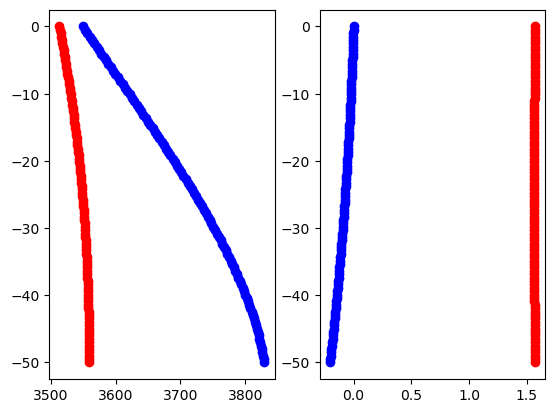

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(np.abs(moose_phasor), z, color='red')
ax1.scatter(np.abs(analytical_phasor), z, color='blue')

ax2.scatter(-np.angle(moose_phasor), z, color='red')
ax2.scatter(-np.angle(analytical_phasor), z, color='blue')

## Plot time series

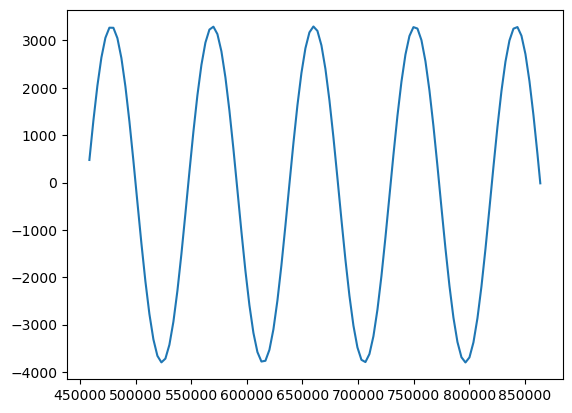

In [10]:
fig,ax = plt.subplots()
plt.plot(results.time[trim], porepressure[-1,:]-np.mean(porepressure[-1,:]))
plt.show()